# Installing requirements

`pip install -r requirements.txt`


# Import and connections

In [19]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras


# Data load

Датасет **M4 Monthly** хранится в wide-формате: в каждой строке отдельный временной ряд (ID в `V1`), значения по месяцам в `V2..V2795` (в train) и `V2..V19` (в test). После окончания ряда идут `NaN`.


In [20]:
train_path = "/home/plutus/datasets/M4/Monthly-train.csv"
test_path = "/home/plutus/datasets/M4/Monthly-test.csv"

train_df = pd.read_csv(train_path).set_index("V1")
test_df = pd.read_csv(test_path).set_index("V1")

common_ids = train_df.index.intersection(test_df.index)
train_df = train_df.loc[common_ids]
test_df = test_df.loc[common_ids]

print("train shape:", train_df.shape)
print("test shape:", test_df.shape)

# Горизонт прогноза (для Monthly обычно 18)
horizon = int(test_df.notna().sum(axis=1).mode().iloc[0])
print("forecast horizon:", horizon)

train_lengths = train_df.notna().sum(axis=1)
print("train length stats:\n", train_lengths.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).to_string())


train shape: (48000, 2794)
test shape: (48000, 18)
forecast horizon: 18
train length stats:
 count    48000.000000
mean       216.300229
std        137.406295
min         42.000000
10%         69.000000
25%         82.000000
50%        202.000000
75%        306.000000
90%        354.000000
max       2794.000000


# Preparation

Сделаем supervised-датасет для **one-step** прогноза:
- вход: окно длиной `LOOK_BACK`
- цель: следующее значение

Далее используем **рекурсивный прогноз** (recursive / autoregressive): для горизонта `h` будем подавать предсказания обратно во входное окно.


In [21]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

LOOK_BACK = 36
MAX_SERIES = 2000          # чтобы обучение было быстрым; можно увеличить
MAX_WINDOWS = 30_000      # ограничение на число обучающих примеров
BATCH_SIZE = 1024
EPOCHS = 10

rng = np.random.default_rng(SEED)


In [22]:
def row_to_values(row: pd.Series) -> np.ndarray:
    values = row.to_numpy(dtype=np.float32)
    values = values[~np.isnan(values)]
    return values


def standardize(values: np.ndarray):
    mu = float(values.mean())
    sigma = float(values.std())
    if sigma < 1e-6:
        sigma = 1.0
    scaled = (values - mu) / sigma
    return scaled.astype(np.float32), mu, sigma


def sample_windows(values_scaled: np.ndarray, look_back: int, max_windows: int, rng: np.random.Generator):
    n = len(values_scaled) - look_back
    if n <= 0:
        return None, None

    if n > max_windows:
        starts = rng.choice(n, size=max_windows, replace=False)
    else:
        starts = np.arange(n)

    X = np.stack([values_scaled[s : s + look_back] for s in starts]).astype(np.float32)
    y = values_scaled[starts + look_back].astype(np.float32)

    return X[..., None], y


## Build training windows

In [23]:
ids = train_df.index.to_numpy()
if MAX_SERIES < len(ids):
    ids = rng.choice(ids, size=MAX_SERIES, replace=False)

X_parts = []
y_parts = []
series_params = {}  # id -> (mu, sigma)

collected = 0
for sid in ids:
    train_values = row_to_values(train_df.loc[sid])
    if len(train_values) <= LOOK_BACK:
        continue

    train_scaled, mu, sigma = standardize(train_values)
    series_params[sid] = (mu, sigma)

    # равномерно ограничиваем число окон с одного ряда
    per_series_cap = max(1, MAX_WINDOWS // max(1, len(ids)))
    X, y = sample_windows(train_scaled, LOOK_BACK, per_series_cap, rng)
    if X is None:
        continue

    if collected + len(y) > MAX_WINDOWS:
        keep = MAX_WINDOWS - collected
        X = X[:keep]
        y = y[:keep]

    X_parts.append(X)
    y_parts.append(y)
    collected += len(y)

    if collected >= MAX_WINDOWS:
        break

X = np.concatenate(X_parts, axis=0)
y = np.concatenate(y_parts, axis=0)

print("windows:", X.shape, y.shape)


windows: (29997, 36, 1) (29997,)


# Train model (RNN / LSTM)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

model = keras.Sequential([
    keras.layers.Input(shape=(LOOK_BACK, 1)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(32),
    keras.layers.Dense(1),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"],
)

model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
]

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1,
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 36, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 36, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.4548 - mae: 0.4859 - val_loss: 0.3395 - val_mae: 0.4024
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.3197 - mae: 0.3738 - val_loss: 0.3115 - val_mae: 0.3695
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.3052 - mae: 0.3576 - val_loss: 0.2982 - val_mae: 0.3561
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.2938 - mae: 0.3477 - val_loss: 0.2847 - val_mae: 0.3448
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.2813 - mae: 0.3365 - val_loss: 0.2657 - val_mae: 0.3293
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.2620 - mae: 0.3203 - val_loss: 0.2341 - val_mae: 0.3026
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.2438 - mae: 0.3052 - val_loss: 0.2245 - val_mae: 0.2965
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.2349 - mae: 0.2944 - val_loss: 0.2200 - val_mae: 0.2869
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - lo

# Recursive forecast

Функция ниже делает прогноз на `h` шагов вперёд, каждый раз подавая предсказание обратно во входное окно (recursive forecasting).


In [25]:
def recursive_forecast_scaled(model, last_window_scaled: np.ndarray, horizon: int) -> np.ndarray:
    window = last_window_scaled.astype(np.float32).copy()
    preds = []
    for _ in range(horizon):
        pred = float(model.predict(window[None, :, None], verbose=0)[0, 0])
        preds.append(pred)
        window = np.roll(window, -1)
        window[-1] = pred
    return np.array(preds, dtype=np.float32)


# Evaluation

Посчитаем метрики по подмножеству рядов (чтобы было быстрее).


In [26]:
def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    denom = np.abs(y_true) + np.abs(y_pred)
    denom = np.where(denom == 0, 1.0, denom)
    return float(np.mean(200.0 * np.abs(y_pred - y_true) / denom))


def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_pred - y_true)))


def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))


EVAL_SERIES = 200
ids_eval = list(series_params.keys())
if len(ids_eval) > EVAL_SERIES:
    ids_eval = rng.choice(ids_eval, size=EVAL_SERIES, replace=False).tolist()

metrics = []
for sid in ids_eval:
    train_values = row_to_values(train_df.loc[sid])
    test_values = row_to_values(test_df.loc[sid])
    if len(test_values) == 0:
        continue

    mu, sigma = series_params[sid]
    train_scaled = ((train_values - mu) / sigma).astype(np.float32)

    last_window = train_scaled[-LOOK_BACK:]
    pred_scaled = recursive_forecast_scaled(model, last_window, horizon=len(test_values))
    pred = pred_scaled * sigma + mu

    # baseline: "наивный" прогноз последним значением
    naive = np.full_like(test_values, fill_value=train_values[-1])

    metrics.append({
        "id": sid,
        "smape": smape(test_values, pred),
        "mae": mae(test_values, pred),
        "rmse": rmse(test_values, pred),
        "smape_naive": smape(test_values, naive)
    })

metrics_df = pd.DataFrame(metrics)
print("rows evaluated:", len(metrics_df))
print(metrics_df[["smape", "mae", "rmse", "smape_naive"]].mean().to_string())


rows evaluated: 200
smape            18.449517
mae             912.671399
rmse           1055.796692
smape_naive      16.486100


# Visualization

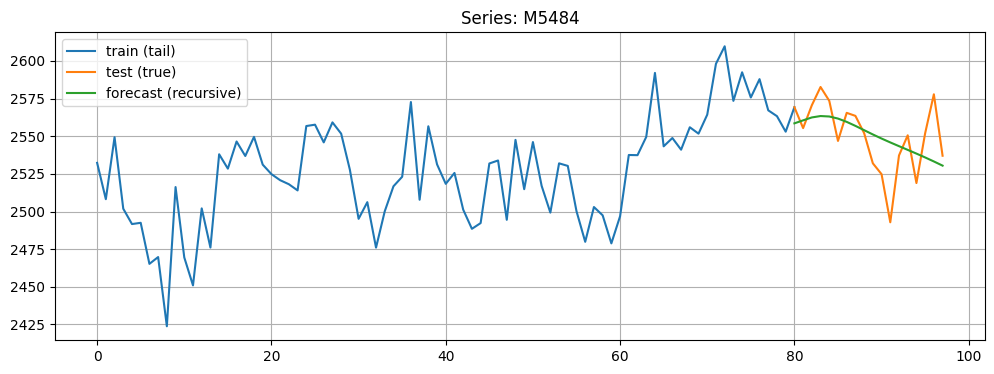

In [27]:
sid = metrics_df.sort_values("smape").iloc[0]["id"]

train_values = row_to_values(train_df.loc[sid])
test_values = row_to_values(test_df.loc[sid])
mu, sigma = series_params[sid]
train_scaled = ((train_values - mu) / sigma).astype(np.float32)

pred_scaled = recursive_forecast_scaled(model, train_scaled[-LOOK_BACK:], horizon=len(test_values))
pred = pred_scaled * sigma + mu

# Покажем последние 80 точек train + test
show_train = train_values[-80:]
# Добавим первую точку test в конец train-хвоста, чтобы линия была непрерывной
show_train = np.append(show_train, test_values[0])
x_train = np.arange(len(show_train))
x_test = np.arange(len(show_train) - 1, (len(show_train) - 1) + len(test_values))

plt.figure(figsize=(12, 4))
plt.plot(x_train, show_train, label="train (tail)")
plt.plot(x_test, test_values, label="test (true)")
plt.plot(x_test, pred, label="forecast (recursive)")
plt.title(f"Series: {sid}")
plt.grid(True)
plt.legend()
plt.show()


# Conclusions

- Построена RNN-модель (LSTM) для one-step прогноза по окну длиной `LOOK_BACK`.
- Для multi-step прогноза реализован рекурсивный подход: предсказания подаются обратно во вход.
- Для оценки качества рассчитаны `sMAPE`, `MAE`, `RMSE` и сравнение с наивным baseline.
